# Hyperparameter Search for Histogram-Based Image Retrieval

This notebook runs comprehensive hyperparameter search experiments for different histogram-based image retrieval methods and the combination of pairs of them as did in Week 1. The methods evaluated include:
- 2D histograms (HSV/LAB/HLS channel pairs)
- 3D histograms (RGB/HSV/LAB/HLS)
- Block histograms (different grid sizes)
- Spatial pyramid histograms (different levels and weighting schemes)

Each experiment evaluates MAP@1 and MAP@5 using L1 distance, histogram intersection and KL-divergence as similarity metrics which were the best performing ones in Week 1.

In [ ]:
# Import Required Libraries
import os, json, hashlib, itertools, re, cv2, pickle, time, warnings
from itertools import product, combinations
from collections import OrderedDict
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Import custom modules
from week2_histograms import Histogram2D, Histogram3D, BlockHistogram, SpatialPyramidHistogram
from similarity_measures_optimized import (
    l1_distance_matrix,
    histogram_intersection_matrix,
    kl_divergence_matrix,
    normalize_hist
)
from image_retrieval import load_ground_truth  
from helper_functions_main import pil_to_cv2, create_histogram_with_bins
from mapk import mapk

print("All libraries imported successfully!")

All libraries imported successfully!


## Setup Paths and Configuration

Define paths for database, query images, ground truth, and create necessary directories for caching and results.

In [2]:
# Setup Paths and Configuration
DEFAULT_DB_PATH = "../Data/BBDD/"
DEFAULT_QSD_PATH = "../Data/Week2/qsd1_w2/"
DEFAULT_GT_PATH = "../Data/Week2/qsd1_w2/gt_corresps.pkl"
CACHE_DIR = "hp_cache/"
RESULTS_DIR = "hp_results/"

# Create directories
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Database path: {DEFAULT_DB_PATH}")
print(f"Query path: {DEFAULT_QSD_PATH}")
print(f"Ground truth path: {DEFAULT_GT_PATH}")
print(f"Cache directory: {CACHE_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Database path: ../Data/BBDD/
Query path: ../Data/Week2/qsd1_w2/
Ground truth path: ../Data/Week2/qsd1_w2/gt_corresps.pkl
Cache directory: hp_cache/
Results directory: hp_results/


## Load Database and Query Images

Load and sort the database and query images from the specified directories.

In [3]:
# Load Database and Query Images
db_images = sorted([f for f in os.listdir(DEFAULT_DB_PATH) if f.lower().endswith('.jpg')])
query_images = sorted([f for f in os.listdir(DEFAULT_QSD_PATH) if f.lower().endswith('.jpg')])

print(f"Database images found: {len(db_images)}")
print(f"Query images found: {len(query_images)}")
print(f"First 5 DB images: {db_images[:5]}")
print(f"First 5 query images: {query_images[:5]}")

Database images found: 287
Query images found: 30
First 5 DB images: ['bbdd_00000.jpg', 'bbdd_00001.jpg', 'bbdd_00002.jpg', 'bbdd_00003.jpg', 'bbdd_00004.jpg']
First 5 query images: ['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg']


## Load Ground Truth Data

Load the ground truth correspondences for evaluation.

In [4]:
# Load Ground Truth Data
gt = load_ground_truth(DEFAULT_GT_PATH)
if gt is None:
    raise RuntimeError("Ground truth not found or invalid.")

print(f"Ground truth loaded successfully!")
print(f"Number of queries in GT: {len(gt)}")
print(f"First few GT entries: {gt[:3]}")

Ground truth loaded successfully!
Number of queries in GT: 30
First few GT entries: [[120], [170], [277]]


## Define Utility Functions

Define helper functions for image processing, descriptor computation, caching, and evaluation.

In [ ]:
# Define Utility Functions

def filename_to_id(fname):
    """Convert a database filename to integer id"""
    base = os.path.splitext(os.path.basename(fname))[0]
    parts = base.split("_")
    try:
        return int(parts[-1])
    except:
        m = re.search(r"\d+", base)
        return int(m.group()) if m else None

def load_image_cv(path):
    """Load image as OpenCV BGR format"""
    pil = Image.open(path).convert("RGB")
    cv_img = pil_to_cv2(pil)
    return cv_img

def compute_db_descriptors(db_images, db_path, descriptor_fn, cache_name=None, recompute=False):
    """Compute descriptor for each db image (with caching)"""
    if cache_name:
        cache_file = os.path.join(CACHE_DIR, f"dbdesc_{cache_name}.pkl")
    else:
        cache_file = None

    if cache_file and (not recompute) and os.path.exists(cache_file):
        try:
            with open(cache_file, "rb") as f:
                cached = pickle.load(f)
            if cached.get("image_list") == db_images:
                print(f"Loaded DB descriptors from cache: {cache_file}")
                return cached["descriptors"]
        except Exception as e:
            print(f"Cache load failed: {e}")

    descriptors = []
    for fname in tqdm(db_images, desc="Computing DB descriptors"):
        path = os.path.join(db_path, fname)
        img = load_image_cv(path)
        desc = descriptor_fn(img)
        desc = np.asarray(desc, dtype=np.float32)
        if desc.sum() > 0:
            desc = desc / desc.sum()
        descriptors.append(desc)

    if cache_file:
        with open(cache_file, "wb") as f:
            pickle.dump({"image_list": db_images, "descriptors": descriptors}, f)
    return descriptors

def compute_query_descriptors(query_images, query_path, descriptor_fn):
    """Compute descriptor for each query image"""
    descriptors = []
    for fname in tqdm(query_images, desc="Computing query descriptors"):
        path = os.path.join(query_path, fname)
        img = load_image_cv(path)
        desc = descriptor_fn(img)
        desc = np.asarray(desc, dtype=np.float32)
        if desc.sum() > 0:
            desc = desc / desc.sum()
        descriptors.append(desc)
    return descriptors

def rank_db_for_queries(Q, DB, sim_func):
    """Rank database images for queries"""
    M = sim_func(Q, DB)
    name = sim_func.__name__
    if name in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
        M = -M
    idxs = np.argsort(M, axis=1)
    return idxs

def evaluate_config(name, desc_fn, db_images, query_images, db_path, qsd_path, gt):
    """Evaluate a single configuration"""
    print(f"Evaluating {name}")
    
    # Compute descriptors
    db_cache_name = f"notebook_{name}"
    DB_descs = compute_db_descriptors(db_images, db_path, desc_fn, cache_name=db_cache_name)
    DB = np.stack([normalize_hist(d) for d in DB_descs])
    
    Q_descs = compute_query_descriptors(query_images, qsd_path, desc_fn)
    Q = np.stack([normalize_hist(d) for d in Q_descs])
    
    results = []
    sim_funcs = [l1_distance_matrix, histogram_intersection_matrix, kl_divergence_matrix]
    
    for sim in sim_funcs:
        rank_idxs = rank_db_for_queries(Q, DB, sim)
        preds_ids = []
        for q_idx in range(rank_idxs.shape[0]):
            topk = rank_idxs[q_idx, :10]
            top_fnames = [db_images[i] for i in topk]
            ids = [filename_to_id(s) for s in top_fnames]
            preds_ids.append(ids)
        
        map1 = mapk(gt, preds_ids, 1)
        map5 = mapk(gt, preds_ids, 5)
        
        results.append({
            "config": name,
            "sim": sim.__name__,
            "MAP@1": map1,
            "MAP@5": map5,
            "db_desc_dim": DB.shape[1]
        })
    
    return results

print("Utility functions defined successfully!")

Utility functions defined successfully!


## 2D Histogram Experiments

Run hyperparameter search for 2D histograms across different color spaces, channel pairs, and bin configurations.

In [6]:
# 2D Histogram Experiments
print("=== Running 2D Histogram Experiments ===")

def make_2d_configs():
    configs = []
    channel_pairs = [(0, 1), (0, 2), (1, 2)]  # H-S, H-V, S-V for HSV
    for cs in ['HSV', 'LAB', 'HLS']:
        for ch in channel_pairs:
            for bins in [(16, 16), (32, 32), (64, 64)]:
                name = f"2D_{cs}_{ch}_bins{bins[0]}x{bins[1]}"
                def make_fn(bins=bins, ch=ch, cs=cs):
                    return lambda img: Histogram2D(bins=bins, channels=ch, color_space=cs).compute(img)
                configs.append((name, make_fn()))
    return configs

# Generate configurations
configs_2d = make_2d_configs()
print(f"Generated {len(configs_2d)} 2D histogram configurations")

# Run experiments
results_2d = []
start_time = time.time()

i = 0
for name, desc_fn in configs_2d:
    print(f"Evaluating config {i + 1}/{len(configs_2d)}")
    config_results = evaluate_config(name, desc_fn, db_images, query_images, 
                                   DEFAULT_DB_PATH, DEFAULT_QSD_PATH, gt)
    results_2d.extend(config_results)
    i += 1

df_2d = pd.DataFrame(results_2d)
print(f"2D experiments completed in {time.time() - start_time:.1f}s")
print(f"Results shape: {df_2d.shape}")

=== Running 2D Histogram Experiments ===
Generated 27 2D histogram configurations
Evaluating config 1/27
Evaluating 2D_HSV_(0, 1)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 1)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 75.80it/s]


Evaluating config 2/27
Evaluating 2D_HSV_(0, 1)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 1)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 104.09it/s]


Evaluating config 3/27
Evaluating 2D_HSV_(0, 1)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 1)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 89.72it/s] 


Evaluating config 4/27
Evaluating 2D_HSV_(0, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 95.28it/s] 


Evaluating config 5/27
Evaluating 2D_HSV_(0, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 100.82it/s]


Evaluating config 6/27
Evaluating 2D_HSV_(0, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(0, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 104.50it/s]


Evaluating config 7/27
Evaluating 2D_HSV_(1, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(1, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 111.97it/s]


Evaluating config 8/27
Evaluating 2D_HSV_(1, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(1, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 110.49it/s]


Evaluating config 9/27
Evaluating 2D_HSV_(1, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HSV_(1, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 104.89it/s]


Evaluating config 10/27
Evaluating 2D_LAB_(0, 1)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 1)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 79.94it/s]


Evaluating config 11/27
Evaluating 2D_LAB_(0, 1)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 1)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 97.36it/s]


Evaluating config 12/27
Evaluating 2D_LAB_(0, 1)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 1)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 98.42it/s]


Evaluating config 13/27
Evaluating 2D_LAB_(0, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 72.69it/s]


Evaluating config 14/27
Evaluating 2D_LAB_(0, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 112.28it/s]


Evaluating config 15/27
Evaluating 2D_LAB_(0, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(0, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 117.12it/s]


Evaluating config 16/27
Evaluating 2D_LAB_(1, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(1, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 109.05it/s]


Evaluating config 17/27
Evaluating 2D_LAB_(1, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(1, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 99.41it/s]


Evaluating config 18/27
Evaluating 2D_LAB_(1, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_LAB_(1, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 95.10it/s]


Evaluating config 19/27
Evaluating 2D_HLS_(0, 1)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 1)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 76.79it/s]


Evaluating config 20/27
Evaluating 2D_HLS_(0, 1)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 1)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 110.78it/s]


Evaluating config 21/27
Evaluating 2D_HLS_(0, 1)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 1)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 115.90it/s]


Evaluating config 22/27
Evaluating 2D_HLS_(0, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 97.34it/s] 


Evaluating config 23/27
Evaluating 2D_HLS_(0, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 103.69it/s]


Evaluating config 24/27
Evaluating 2D_HLS_(0, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(0, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 101.61it/s]


Evaluating config 25/27
Evaluating 2D_HLS_(1, 2)_bins16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(1, 2)_bins16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 57.14it/s]


Evaluating config 26/27
Evaluating 2D_HLS_(1, 2)_bins32x32
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(1, 2)_bins32x32.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 111.23it/s]


Evaluating config 27/27
Evaluating 2D_HLS_(1, 2)_bins64x64
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_2D_HLS_(1, 2)_bins64x64.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 102.18it/s]


2D experiments completed in 22.7s
Results shape: (81, 5)


### Visualize 2D Histogram Results

Create heatmaps showing MAP@1 and MAP@5 performance across different 2D histogram configurations.

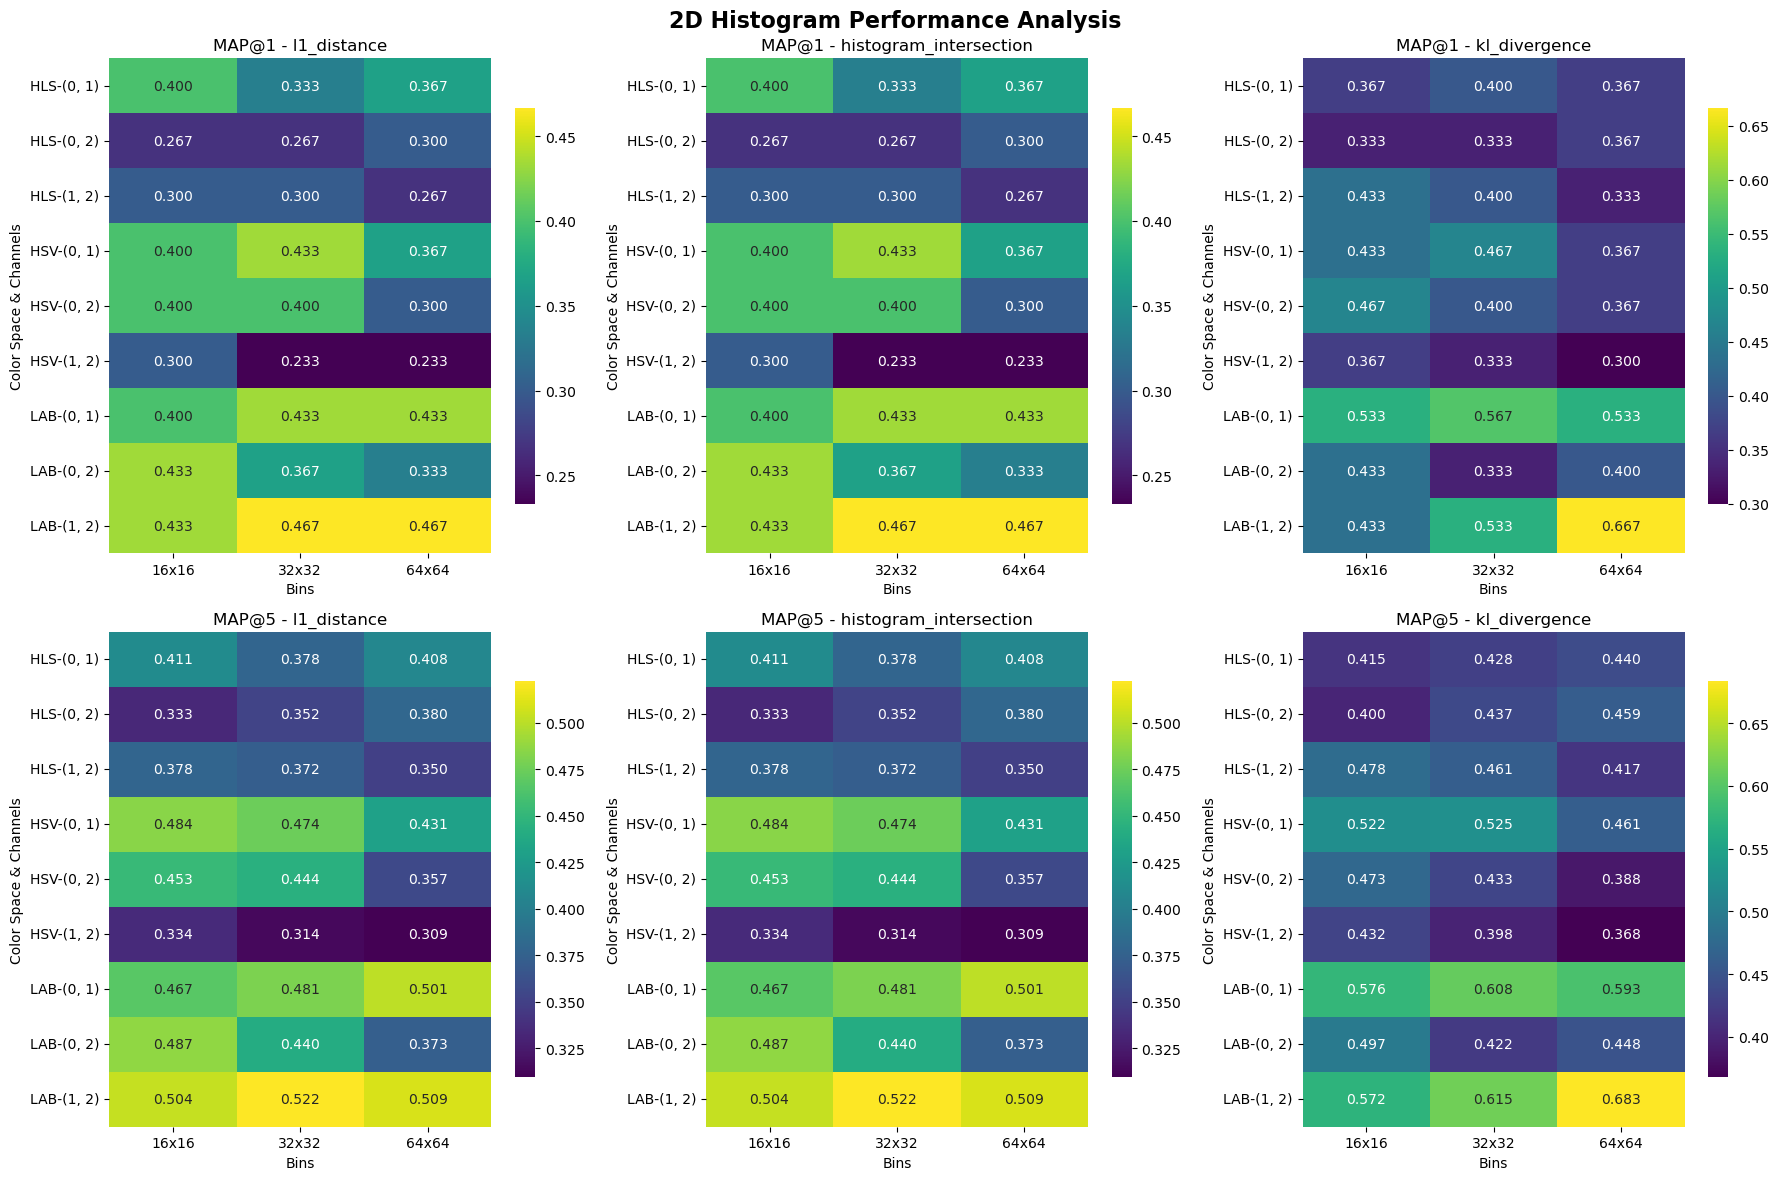


Top 5 2D Histogram Configurations:
                 config                  sim    MAP@1    MAP@5
2D_LAB_(1, 2)_bins64x64 kl_divergence_matrix 0.666667 0.683333
2D_LAB_(0, 1)_bins32x32 kl_divergence_matrix 0.566667 0.608333
2D_LAB_(1, 2)_bins32x32 kl_divergence_matrix 0.533333 0.615000
2D_LAB_(0, 1)_bins64x64 kl_divergence_matrix 0.533333 0.592778
2D_LAB_(0, 1)_bins16x16 kl_divergence_matrix 0.533333 0.576111


In [7]:
# Visualize 2D Histogram Results

# Parse configuration details
def parse_2d_config(config_name):
    parts = config_name.split('_')
    color_space = parts[1]
    channels = parts[2]
    bins = parts[3].replace('bins', '').replace('x', 'x')
    return color_space, channels, bins

df_2d['color_space'] = df_2d['config'].apply(lambda x: parse_2d_config(x)[0])
df_2d['channels'] = df_2d['config'].apply(lambda x: parse_2d_config(x)[1])
df_2d['bins'] = df_2d['config'].apply(lambda x: parse_2d_config(x)[2])

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('2D Histogram Performance Analysis', fontsize=16, fontweight='bold')

metrics = ['MAP@1', 'MAP@5']
sims = ['l1_distance_matrix', 'histogram_intersection_matrix', 'kl_divergence_matrix']

for i, metric in enumerate(metrics):
    for j, sim in enumerate(sims):
        ax = axes[i, j]
        
        # Filter data
        data = df_2d[(df_2d['sim'] == sim)]
        
        # Create pivot table for heatmap
        pivot = data.pivot_table(
            index=['color_space', 'channels'], 
            columns='bins', 
            values=metric, 
            aggfunc='mean'
        )
        
        # Create heatmap
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{metric} - {sim.replace("_matrix", "")}')
        ax.set_xlabel('Bins')
        ax.set_ylabel('Color Space & Channels')

plt.tight_layout()
plt.show()

# Show best 2D configurations (sorted by MAP@1, then MAP@5)
print("\nTop 5 2D Histogram Configurations:")
best_2d = (
    df_2d
    .sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False])
    .head(5)[['config', 'sim', 'MAP@1', 'MAP@5']]
)
print(best_2d.to_string(index=False))

## 3D Histogram Experiments

Run hyperparameter search for 3D histograms across different color spaces and bin configurations.

In [8]:
# 3D Histogram Experiments
print("=== Running 3D Histogram Experiments ===")

def make_3d_configs():
    configs = []
    for cs in ['RGB', 'HSV', 'LAB', 'HLS']:
        for bins in [(4, 4, 4), (8, 8, 8), (16, 16, 16)]:
            name = f"3D_{cs}_bins{bins[0]}x{bins[1]}x{bins[2]}"
            def make_fn(bins=bins, cs=cs):
                return lambda img: Histogram3D(bins=bins, color_space=cs).compute(img)
            configs.append((name, make_fn()))
    return configs

# Generate configurations
configs_3d = make_3d_configs()
print(f"Generated {len(configs_3d)} 3D histogram configurations")

# Run experiments
results_3d = []
start_time = time.time()

i = 0
for name, desc_fn in configs_3d:
    print(f"Evaluating config {i + 1}/{len(configs_3d)}")
    config_results = evaluate_config(name, desc_fn, db_images, query_images, 
                                   DEFAULT_DB_PATH, DEFAULT_QSD_PATH, gt)
    results_3d.extend(config_results)
    i += 1

df_3d = pd.DataFrame(results_3d)
print(f"3D experiments completed in {time.time() - start_time:.1f}s")
print(f"Results shape: {df_3d.shape}")

=== Running 3D Histogram Experiments ===
Generated 12 3D histogram configurations
Evaluating config 1/12
Evaluating 3D_RGB_bins4x4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_RGB_bins4x4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 98.98it/s]


Evaluating config 2/12
Evaluating 3D_RGB_bins8x8x8
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_RGB_bins8x8x8.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 112.58it/s]


Evaluating config 3/12
Evaluating 3D_RGB_bins16x16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_RGB_bins16x16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 110.51it/s]


Evaluating config 4/12
Evaluating 3D_HSV_bins4x4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HSV_bins4x4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 106.03it/s]


Evaluating config 5/12
Evaluating 3D_HSV_bins8x8x8
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HSV_bins8x8x8.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 73.61it/s]


Evaluating config 6/12
Evaluating 3D_HSV_bins16x16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HSV_bins16x16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 102.83it/s]


Evaluating config 7/12
Evaluating 3D_LAB_bins4x4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_LAB_bins4x4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 94.50it/s]


Evaluating config 8/12
Evaluating 3D_LAB_bins8x8x8
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_LAB_bins8x8x8.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 101.41it/s]


Evaluating config 9/12
Evaluating 3D_LAB_bins16x16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_LAB_bins16x16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 86.74it/s]


Evaluating config 10/12
Evaluating 3D_HLS_bins4x4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HLS_bins4x4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 68.22it/s]


Evaluating config 11/12
Evaluating 3D_HLS_bins8x8x8
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HLS_bins8x8x8.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 100.54it/s]


Evaluating config 12/12
Evaluating 3D_HLS_bins16x16x16
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_3D_HLS_bins16x16x16.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 108.44it/s]


3D experiments completed in 9.3s
Results shape: (36, 5)


### Visualize 3D Histogram Results

Create bar plots and heatmaps showing the performance of 3D histogram configurations.

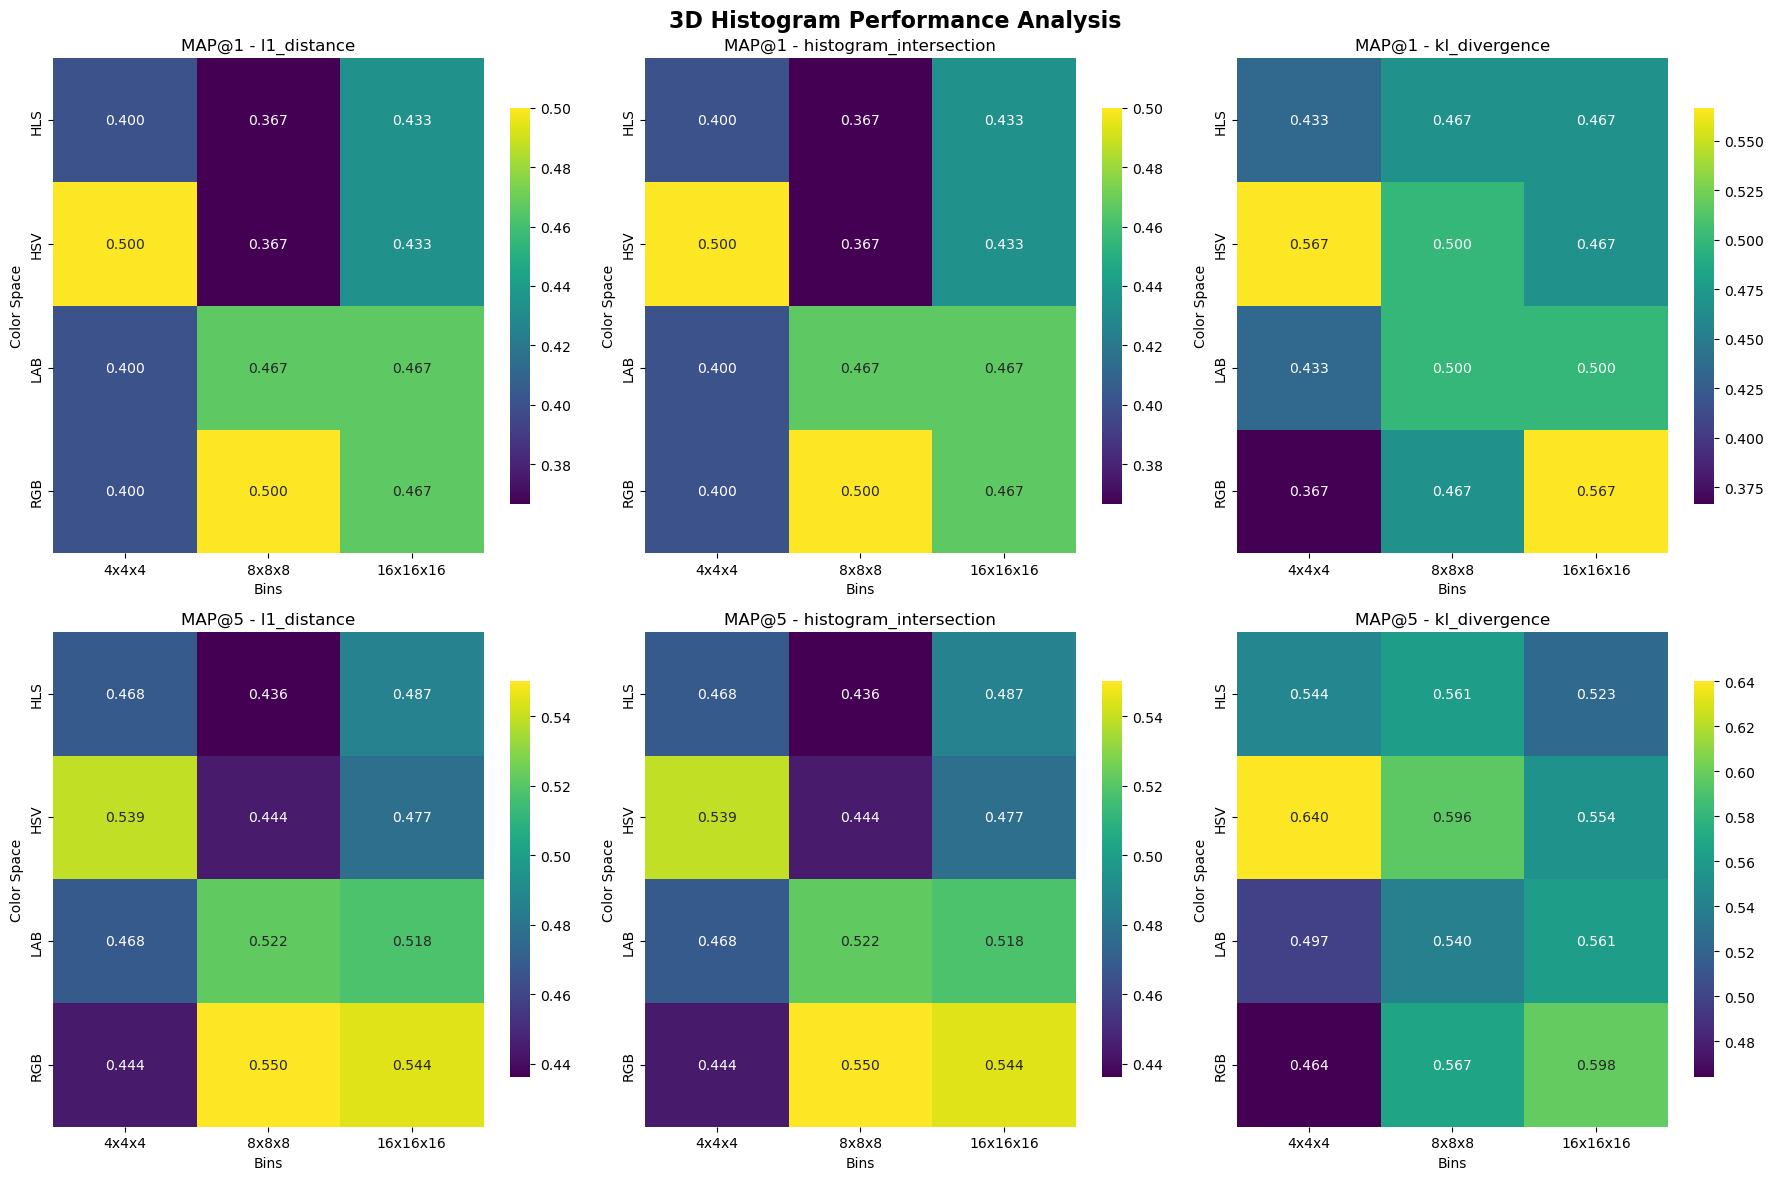


Top 5 3D Histogram Configurations:
             config                  sim    MAP@1    MAP@5
   3D_HSV_bins4x4x4 kl_divergence_matrix 0.566667 0.640000
3D_RGB_bins16x16x16 kl_divergence_matrix 0.566667 0.597778
   3D_HSV_bins8x8x8 kl_divergence_matrix 0.500000 0.595556
3D_LAB_bins16x16x16 kl_divergence_matrix 0.500000 0.561111
   3D_RGB_bins8x8x8   l1_distance_matrix 0.500000 0.550000


In [9]:
# Visualize 3D Histogram Results

# Parse configuration details
def parse_3d_config(config_name):
    parts = config_name.split('_')
    color_space = parts[1]
    bins = parts[2].replace('bins', '').replace('x', 'x')
    return color_space, bins

df_3d['color_space'] = df_3d['config'].apply(lambda x: parse_3d_config(x)[0])
df_3d['bins'] = df_3d['config'].apply(lambda x: parse_3d_config(x)[1])

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('3D Histogram Performance Analysis', fontsize=16, fontweight='bold')

metrics = ['MAP@1', 'MAP@5']
sims = ['l1_distance_matrix', 'histogram_intersection_matrix', 'kl_divergence_matrix']

for i, metric in enumerate(metrics):
    for j, sim in enumerate(sims):
        ax = axes[i, j]
        
        # Filter data
        data = df_3d[df_3d['sim'] == sim]
        
        # Create pivot table
        pivot = data.pivot_table(
            index='color_space', 
            columns='bins', 
            values=metric, 
            aggfunc='mean'
        )
        
        # Ensure correct bin order
        desired_order = ['4x4x4', '8x8x8', '16x16x16']
        
        pivot = pivot.reindex(columns=desired_order)      
        # Create heatmap
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{metric} - {sim.replace("_matrix", "")}')
        ax.set_xlabel('Bins')
        ax.set_ylabel('Color Space')

plt.tight_layout()
plt.show()

# Show best 3D configurations (sorted by MAP@1, then MAP@5)
print("\nTop 5 3D Histogram Configurations:")
best_3d = (
    df_3d
    .sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False])
    .head(5)[['config', 'sim', 'MAP@1', 'MAP@5']]
)
print(best_3d.to_string(index=False))

## Block Histogram Experiments

Run hyperparameter search for block histograms with different grid sizes, color spaces, and bin configurations.

In [10]:
# Block Histogram Experiments
print("=== Running Block Histogram Experiments ===")

def make_block_configs():
    configs = []
    grids = [(2, 2), (3, 3), (4, 4)]
    color_spaces = ['LAB', 'HSV', 'HLS'] # RGB removed
    bins_choices = [(4, 4, 4), (8, 8, 8)]
    for cs in color_spaces:
        for bins in bins_choices:
            for grid in grids:
                name = f"BLOCK_{cs}_bins{bins[0]}_grid{grid[0]}x{grid[1]}"
                def make_fn(bins=bins, cs=cs, grid=grid):
                    return lambda img: BlockHistogram(bins=bins, grid=grid, color_space=cs).compute(img)
                configs.append((name, make_fn()))
    return configs

# Generate configurations
configs_block = make_block_configs()
print(f"Generated {len(configs_block)} block histogram configurations")

# Run experiments
results_block = []
start_time = time.time()

i = 0
for name, desc_fn in configs_block:
    print(f"Evaluating config {i + 1}/{len(configs_block)}")
    i += 1
    config_results = evaluate_config(name, desc_fn, db_images, query_images, 
                                   DEFAULT_DB_PATH, DEFAULT_QSD_PATH, gt)
    results_block.extend(config_results)

df_block = pd.DataFrame(results_block)
print(f"Block experiments completed in {time.time() - start_time:.1f}s")
print(f"Results shape: {df_block.shape}")

=== Running Block Histogram Experiments ===
Generated 18 block histogram configurations
Evaluating config 1/18
Evaluating BLOCK_LAB_bins4_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins4_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 72.55it/s]


Evaluating config 2/18
Evaluating BLOCK_LAB_bins4_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins4_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 87.98it/s]


Evaluating config 3/18
Evaluating BLOCK_LAB_bins4_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins4_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 79.24it/s]


Evaluating config 4/18
Evaluating BLOCK_LAB_bins8_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins8_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 49.98it/s]


Evaluating config 5/18
Evaluating BLOCK_LAB_bins8_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins8_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 92.23it/s] 


Evaluating config 6/18
Evaluating BLOCK_LAB_bins8_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_LAB_bins8_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 72.08it/s]


Evaluating config 7/18
Evaluating BLOCK_HSV_bins4_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins4_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 90.02it/s]


Evaluating config 8/18
Evaluating BLOCK_HSV_bins4_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins4_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 86.32it/s] 


Evaluating config 9/18
Evaluating BLOCK_HSV_bins4_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins4_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 93.25it/s]


Evaluating config 10/18
Evaluating BLOCK_HSV_bins8_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins8_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 92.64it/s]


Evaluating config 11/18
Evaluating BLOCK_HSV_bins8_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins8_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 58.77it/s]


Evaluating config 12/18
Evaluating BLOCK_HSV_bins8_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HSV_bins8_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 97.41it/s]


Evaluating config 13/18
Evaluating BLOCK_HLS_bins4_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins4_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 63.07it/s]


Evaluating config 14/18
Evaluating BLOCK_HLS_bins4_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins4_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 79.84it/s]


Evaluating config 15/18
Evaluating BLOCK_HLS_bins4_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins4_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 90.01it/s]


Evaluating config 16/18
Evaluating BLOCK_HLS_bins8_grid2x2
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins8_grid2x2.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 93.59it/s]


Evaluating config 17/18
Evaluating BLOCK_HLS_bins8_grid3x3
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins8_grid3x3.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 70.49it/s]


Evaluating config 18/18
Evaluating BLOCK_HLS_bins8_grid4x4
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_BLOCK_HLS_bins8_grid4x4.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 103.74it/s]


Block experiments completed in 21.4s
Results shape: (54, 5)


### Visualize Block Histogram Results

Create visualizations showing the impact of grid size and color space on block histogram performance.

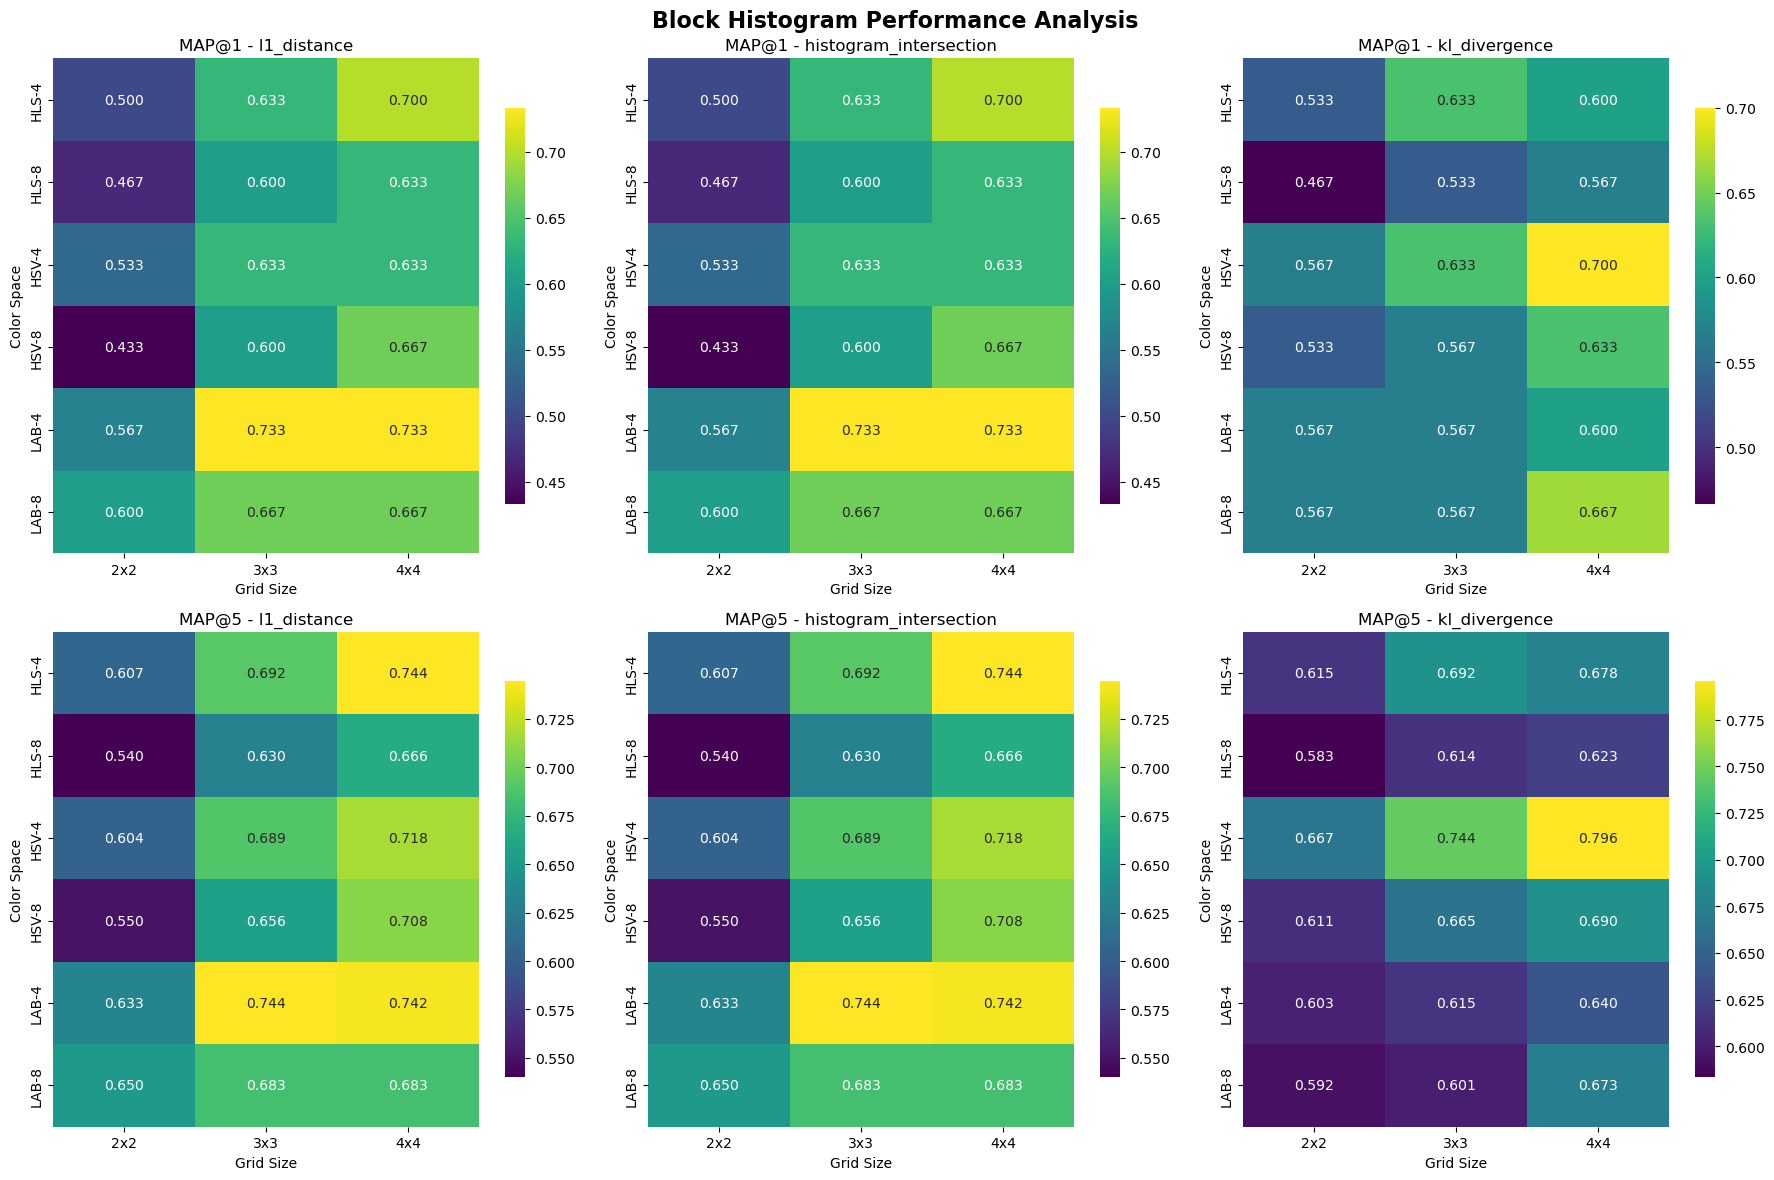


Top 5 Block Histogram Configurations:
                 config                           sim    MAP@1    MAP@5
BLOCK_LAB_bins4_grid3x3            l1_distance_matrix 0.733333 0.744444
BLOCK_LAB_bins4_grid3x3 histogram_intersection_matrix 0.733333 0.744444
BLOCK_LAB_bins4_grid4x4            l1_distance_matrix 0.733333 0.741667
BLOCK_LAB_bins4_grid4x4 histogram_intersection_matrix 0.733333 0.741667
BLOCK_HSV_bins4_grid4x4          kl_divergence_matrix 0.700000 0.795556


In [11]:
# Visualize Block Histogram Results

# Parse configuration details
def parse_block_config(config_name):
    parts = config_name.split('_')
    color_space = parts[1]
    bins = parts[2].replace('bins', '')
    grid = parts[3].replace('grid', '').replace('x', 'x')
    return color_space, bins, grid

df_block['color_space'] = df_block['config'].apply(lambda x: parse_block_config(x)[0])
df_block['bins'] = df_block['config'].apply(lambda x: parse_block_config(x)[1])
df_block['grid'] = df_block['config'].apply(lambda x: parse_block_config(x)[2])

# Ensure grid order
desired_grid_order = ['2x2', '3x3', '4x4']

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Block Histogram Performance Analysis', fontsize=16, fontweight='bold')

metrics = ['MAP@1', 'MAP@5']
sims = ['l1_distance_matrix', 'histogram_intersection_matrix', 'kl_divergence_matrix']

for i, metric in enumerate(metrics):
    for j, sim in enumerate(sims):
        ax = axes[i, j]

        # Filter data for the given similarity metric
        data = df_block[df_block['sim'] == sim]

        # Create pivot table: color_space x grid, averaged over bins
        pivot = data.pivot_table(
            index=['color_space', 'bins'],
            columns='grid',
            values=metric,
            aggfunc='mean'
        )

        # Ensure correct grid order
        pivot = pivot.reindex(columns=[g for g in desired_grid_order if g in pivot.columns])

        # Create heatmap
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis', ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{metric} - {sim.replace("_matrix", "")}')
        ax.set_xlabel('Grid Size')
        ax.set_ylabel('Color Space')

plt.tight_layout()
plt.show()

# Show best block configurations (sorted by MAP@1, then MAP@5)
print("\nTop 5 Block Histogram Configurations:")

best_block = (
    df_block
    .sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False])
    .head(5)[['config', 'sim', 'MAP@1', 'MAP@5']]
)

print(best_block.to_string(index=False))


## Pyramid Histogram Experiments

Run hyperparameter search for spatial pyramid histograms with different levels, weighting schemes, color spaces, and bin configurations.

In [12]:
# Pyramid Histogram Experiments
print("=== Running Pyramid Histogram Experiments ===")

def make_pyramid_configs():
    configs = []
    levels_choices = [2, 3, 4]
    weightings = ['uniform', 'geometric'] 
    color_spaces = ['LAB', 'HSV', 'HLS'] # RGB removed
    bins_choices = [(4, 4, 4), (8, 8, 8)]
    for cs in color_spaces:
        for bins in bins_choices:
            for levels in levels_choices:
                for w in weightings:
                    name = f"PYR_{cs}_bins{bins[0]}_L{levels}_{w}"
                    def make_fn(bins=bins, cs=cs, levels=levels, w=w):
                        return lambda img: SpatialPyramidHistogram(bins=bins, levels=levels, color_space=cs, weights=w).compute(img)
                    configs.append((name, make_fn()))
    return configs

# Generate configurations
configs_pyramid = make_pyramid_configs()
print(f"Generated {len(configs_pyramid)} pyramid histogram configurations")

# Run experiments
results_pyramid = []
start_time = time.time()

i = 0
for name, desc_fn in configs_pyramid:
    print(f"Evaluating config {i + 1}/{len(configs_pyramid)}")
    i += 1
    config_results = evaluate_config(name, desc_fn, db_images, query_images, 
                                   DEFAULT_DB_PATH, DEFAULT_QSD_PATH, gt)
    results_pyramid.extend(config_results)

df_pyramid = pd.DataFrame(results_pyramid)
print(f"Pyramid experiments completed in {time.time() - start_time:.1f}s")
print(f"Results shape: {df_pyramid.shape}")

=== Running Pyramid Histogram Experiments ===
Generated 36 pyramid histogram configurations
Evaluating config 1/36
Evaluating PYR_LAB_bins4_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 78.52it/s]


Evaluating config 2/36
Evaluating PYR_LAB_bins4_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 79.68it/s]


Evaluating config 3/36
Evaluating PYR_LAB_bins4_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 57.06it/s]


Evaluating config 4/36
Evaluating PYR_LAB_bins4_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 56.92it/s]


Evaluating config 5/36
Evaluating PYR_LAB_bins4_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 43.93it/s]


Evaluating config 6/36
Evaluating PYR_LAB_bins4_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins4_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 45.57it/s]


Evaluating config 7/36
Evaluating PYR_LAB_bins8_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 75.20it/s]


Evaluating config 8/36
Evaluating PYR_LAB_bins8_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 76.37it/s]


Evaluating config 9/36
Evaluating PYR_LAB_bins8_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 67.04it/s]


Evaluating config 10/36
Evaluating PYR_LAB_bins8_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 64.89it/s]


Evaluating config 11/36
Evaluating PYR_LAB_bins8_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 49.09it/s]


Evaluating config 12/36
Evaluating PYR_LAB_bins8_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_LAB_bins8_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


Evaluating config 13/36
Evaluating PYR_HSV_bins4_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 47.13it/s]


Evaluating config 14/36
Evaluating PYR_HSV_bins4_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 62.53it/s]


Evaluating config 15/36
Evaluating PYR_HSV_bins4_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 54.55it/s]


Evaluating config 16/36
Evaluating PYR_HSV_bins4_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 64.49it/s]


Evaluating config 17/36
Evaluating PYR_HSV_bins4_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 49.64it/s]


Evaluating config 18/36
Evaluating PYR_HSV_bins4_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins4_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 54.99it/s]


Evaluating config 19/36
Evaluating PYR_HSV_bins8_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 86.65it/s]


Evaluating config 20/36
Evaluating PYR_HSV_bins8_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 55.32it/s]


Evaluating config 21/36
Evaluating PYR_HSV_bins8_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 70.13it/s]


Evaluating config 22/36
Evaluating PYR_HSV_bins8_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 32.89it/s]


Evaluating config 23/36
Evaluating PYR_HSV_bins8_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 56.87it/s]


Evaluating config 24/36
Evaluating PYR_HSV_bins8_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HSV_bins8_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 56.83it/s]


Evaluating config 25/36
Evaluating PYR_HLS_bins4_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 83.91it/s]


Evaluating config 26/36
Evaluating PYR_HLS_bins4_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 90.75it/s]


Evaluating config 27/36
Evaluating PYR_HLS_bins4_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 75.75it/s]


Evaluating config 28/36
Evaluating PYR_HLS_bins4_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 75.04it/s]


Evaluating config 29/36
Evaluating PYR_HLS_bins4_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 60.36it/s]


Evaluating config 30/36
Evaluating PYR_HLS_bins4_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins4_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 63.16it/s]


Evaluating config 31/36
Evaluating PYR_HLS_bins8_L2_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L2_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 91.26it/s] 


Evaluating config 32/36
Evaluating PYR_HLS_bins8_L2_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L2_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 86.03it/s]


Evaluating config 33/36
Evaluating PYR_HLS_bins8_L3_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L3_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 74.72it/s]


Evaluating config 34/36
Evaluating PYR_HLS_bins8_L3_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L3_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 71.88it/s]


Evaluating config 35/36
Evaluating PYR_HLS_bins8_L4_uniform
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L4_uniform.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 58.73it/s]


Evaluating config 36/36
Evaluating PYR_HLS_bins8_L4_geometric
Loaded DB descriptors from cache: hp_cache/dbdesc_notebook_PYR_HLS_bins8_L4_geometric.pkl


Computing query descriptors: 100%|██████████| 30/30 [00:00<00:00, 62.27it/s]


Pyramid experiments completed in 129.6s
Results shape: (108, 5)


### Visualize Pyramid Histogram Results

Create comprehensive visualizations showing the effect of pyramid levels, weighting schemes, and color spaces on performance.

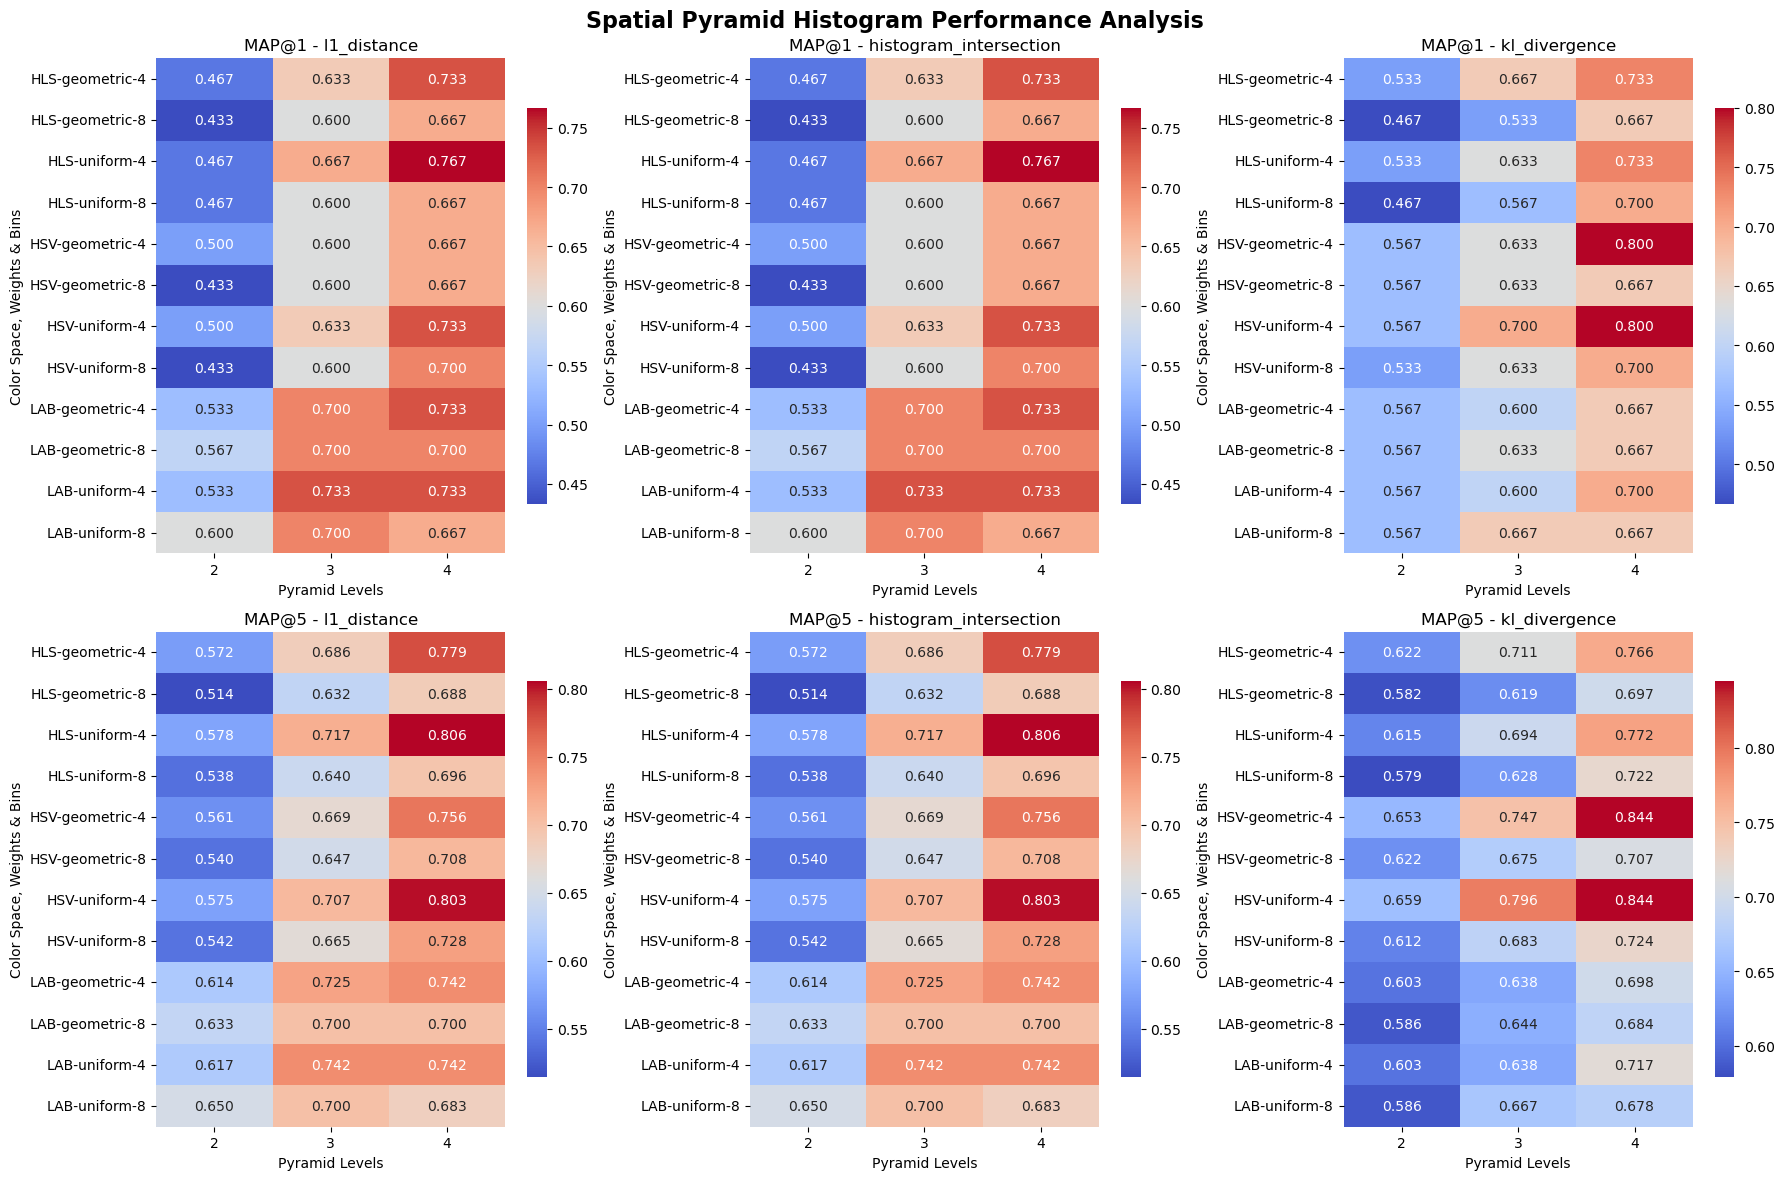


Top 5 Pyramid Histogram Configurations:
                    config                           sim    MAP@1    MAP@5
  PYR_HSV_bins4_L4_uniform          kl_divergence_matrix 0.800000 0.844444
PYR_HSV_bins4_L4_geometric          kl_divergence_matrix 0.800000 0.844444
  PYR_HLS_bins4_L4_uniform            l1_distance_matrix 0.766667 0.805556
  PYR_HLS_bins4_L4_uniform histogram_intersection_matrix 0.766667 0.805556
  PYR_HSV_bins4_L4_uniform            l1_distance_matrix 0.733333 0.802778


In [13]:
# Visualize Pyramid Histogram Results

# Parse configuration details
def parse_pyramid_config(config_name):
    parts = config_name.split('_')
    color_space = parts[1]
    bins = parts[2].replace('bins', '')
    levels = parts[3].replace('L', '')
    weights = parts[4]
    return color_space, bins, levels, weights

df_pyramid['color_space'] = df_pyramid['config'].apply(lambda x: parse_pyramid_config(x)[0])
df_pyramid['bins'] = df_pyramid['config'].apply(lambda x: parse_pyramid_config(x)[1])
df_pyramid['levels'] = df_pyramid['config'].apply(lambda x: parse_pyramid_config(x)[2])
df_pyramid['weights'] = df_pyramid['config'].apply(lambda x: parse_pyramid_config(x)[3])

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Spatial Pyramid Histogram Performance Analysis', fontsize=16, fontweight='bold')

metrics = ['MAP@1', 'MAP@5']
sims = ['l1_distance_matrix', 'histogram_intersection_matrix', 'kl_divergence_matrix']

for i, metric in enumerate(metrics):
    for j, sim in enumerate(sims):
        ax = axes[i, j]
        
        # Filter data
        data = df_pyramid[df_pyramid['sim'] == sim]
        
        # Create pivot table
        pivot = data.pivot_table(
            index=['color_space', 'weights', 'bins'],
            columns='levels',
            values=metric, 
            aggfunc='mean'
        )
        
        # Create heatmap
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='coolwarm', ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{metric} - {sim.replace("_matrix", "")}')
        ax.set_xlabel('Pyramid Levels')
        ax.set_ylabel('Color Space, Weights & Bins')

plt.tight_layout()
plt.show()

# Show best pyramid configurations (sorted by MAP@1, then MAP@5)
print("\nTop 5 Pyramid Histogram Configurations:")
best_pyramid = (
    df_pyramid
    .sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False])
    .head(5)[['config', 'sim', 'MAP@1', 'MAP@5']]
)
print(best_pyramid.to_string(index=False))

## Compare All Methods

Create a final comparison visualization showing the best performing configuration from each method type.

=== BEST CONFIGURATION FROM EACH METHOD (prioritizing MAP@1, then MAP@5) ===
           Method              Best_Config           Similarity    MAP@1    MAP@5  Descriptor_Dim
     2D Histogram  2D_LAB_(1, 2)_bins64x64 kl_divergence_matrix 0.666667 0.683333            4096
     3D Histogram         3D_HSV_bins4x4x4 kl_divergence_matrix 0.566667 0.640000              64
  Block Histogram  BLOCK_LAB_bins4_grid3x3   l1_distance_matrix 0.733333 0.744444             576
Pyramid Histogram PYR_HSV_bins4_L4_uniform kl_divergence_matrix 0.800000 0.844444            5440


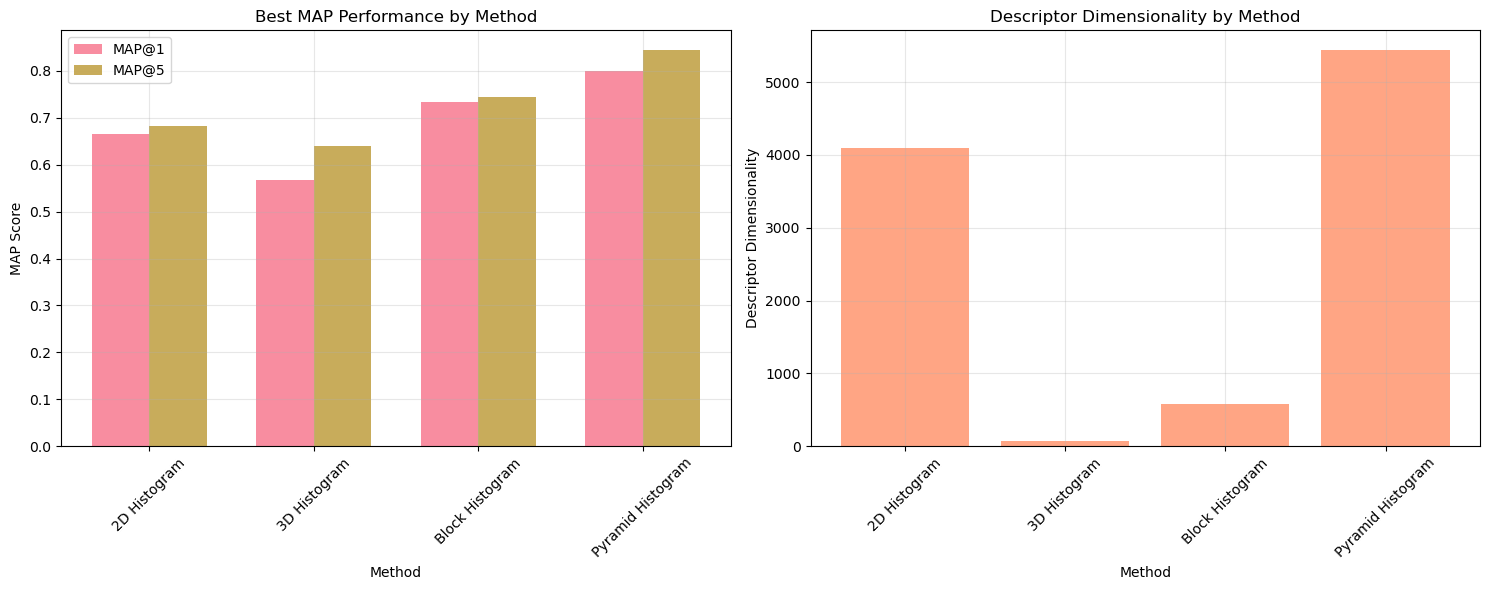


All results saved to: hp_results/all_results_20251011_123954.csv
Total configurations tested: 93
Overall best MAP@1: 0.8000
Overall best MAP@5: 0.8444
Overall best configuration: PYR_HSV_bins4_L4_uniform
Method type: PYR


In [14]:
# Compare All Methods

# Helper function to select the best configuration prioritizing MAP@1, then MAP@5
def best_by_map1_then_map5(df):
    return df.sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False]).iloc[0]

# Find best configuration from each method
best_2d_overall = best_by_map1_then_map5(df_2d)
best_3d_overall = best_by_map1_then_map5(df_3d)
best_block_overall = best_by_map1_then_map5(df_block)
best_pyramid_overall = best_by_map1_then_map5(df_pyramid)

# Create comparison dataframe
comparison_data = {
    'Method': ['2D Histogram', '3D Histogram', 'Block Histogram', 'Pyramid Histogram'],
    'Best_Config': [
        best_2d_overall['config'], best_3d_overall['config'],
        best_block_overall['config'], best_pyramid_overall['config']
    ],
    'Similarity': [
        best_2d_overall['sim'], best_3d_overall['sim'],
        best_block_overall['sim'], best_pyramid_overall['sim']
    ],
    'MAP@1': [
        best_2d_overall['MAP@1'], best_3d_overall['MAP@1'],
        best_block_overall['MAP@1'], best_pyramid_overall['MAP@1']
    ],
    'MAP@5': [
        best_2d_overall['MAP@5'], best_3d_overall['MAP@5'],
        best_block_overall['MAP@5'], best_pyramid_overall['MAP@5']
    ],
    'Descriptor_Dim': [
        best_2d_overall['db_desc_dim'], best_3d_overall['db_desc_dim'],
        best_block_overall['db_desc_dim'], best_pyramid_overall['db_desc_dim']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("=== BEST CONFIGURATION FROM EACH METHOD (prioritizing MAP@1, then MAP@5) ===")
print(df_comparison.to_string(index=False))

# --- Visualization (unchanged) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# MAP comparison
x_pos = np.arange(len(df_comparison['Method']))
width = 0.35

ax1.bar(x_pos - width/2, df_comparison['MAP@1'], width, label='MAP@1', alpha=0.8)
ax1.bar(x_pos + width/2, df_comparison['MAP@5'], width, label='MAP@5', alpha=0.8)
ax1.set_xlabel('Method')
ax1.set_ylabel('MAP Score')
ax1.set_title('Best MAP Performance by Method')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_comparison['Method'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Descriptor dimensionality comparison
ax2.bar(df_comparison['Method'], df_comparison['Descriptor_Dim'], color='coral', alpha=0.7)
ax2.set_xlabel('Method')
ax2.set_ylabel('Descriptor Dimensionality')
ax2.set_title('Descriptor Dimensionality by Method')
ax2.set_xticklabels(df_comparison['Method'], rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save all results
timestamp = time.strftime("%Y%m%d_%H%M%S")
results_file = os.path.join(RESULTS_DIR, f"all_results_{timestamp}.csv")

# Combine all results
all_results = pd.concat([df_2d, df_3d, df_block, df_pyramid], ignore_index=True)
all_results['method_type'] = all_results['config'].apply(lambda x: x.split('_')[0])
all_results.to_csv(results_file, index=False)

# --- Find overall best configuration (prioritizing MAP@1, then MAP@5) ---
best_overall = (
    all_results
    .sort_values(by=['MAP@1', 'MAP@5'], ascending=[False, False])
    .iloc[0]
)

print(f"\nAll results saved to: {results_file}")
print(f"Total configurations tested: {len(all_results)//3}")  # Divide by 3 because we test 3 similarity measures
print(f"Overall best MAP@1: {best_overall['MAP@1']:.4f}")
print(f"Overall best MAP@5: {best_overall['MAP@5']:.4f}")
print(f"Overall best configuration: {best_overall['config']}")
print(f"Method type: {best_overall['method_type']}")


## Experiment: Grid-Based Histogram Optimization
This experiment aims with the best combination of bins and grids for the new histogram descriptors to evaluate their performance using similarity measures with ponderation.

In [ ]:
# ------------------------------
# Utils: safe filename + hashing
# ------------------------------
def _safe_name(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '-', s)

def _list_hash(items) -> str:
    m = hashlib.md5()
    for it in items:
        m.update(str(it).encode('utf-8'))
        m.update(b'|')
    return m.hexdigest()[:10]

# ----------------------------------------------------------------
# Build descriptor matrix with caching + tqdm (per descriptor file)
# ----------------------------------------------------------------
def build_descriptor_matrix_cached(
    desc_fn_list,              # [(name, fn), ...]
    filenames,                 # list of image filenames
    base_path,                 # folder where filenames live
    cache_dir="hp_cache",      # cache directory
    cache_prefix="desc",       # e.g., "2D_db" or "2D_q"
    normalize=True,
    flatten=True
):
    os.makedirs(cache_dir, exist_ok=True)
    descs = []

    # hash the image list + path to keep cache valid per dataset/version
    dataset_sig = _list_hash([base_path] + list(filenames))

    for (name, fn) in tqdm(desc_fn_list, desc=f"Building descriptors ({cache_prefix})", unit="desc"):
        safe = _safe_name(name)
        cache_file = os.path.join(cache_dir, f"{cache_prefix}_{safe}_{dataset_sig}.pkl")

        # Try load cache
        if os.path.exists(cache_file):
            try:
                with open(cache_file, "rb") as f:
                    cached = pickle.load(f)
                if cached.get("image_list") == list(filenames):
                    descs.append(cached["descriptors"])
                    continue
            except Exception:
                pass  # fallback to recompute

        # Compute and cache
        vecs = []
        for fname in tqdm(filenames, desc=f"[{cache_prefix}] {name}", leave=False):
            img = load_image_cv(os.path.join(base_path, fname))  # must return BGR np.ndarray
            if not isinstance(img, np.ndarray):
                raise ValueError(f"Failed to load as ndarray: {fname}")
            v = fn(img)
            v = np.asarray(v, dtype=np.float32)
            if flatten and v.ndim > 1:
                v = v.ravel()
            if normalize and v.sum() > 0:
                v = v / v.sum()
            vecs.append(v)

        mat = np.stack(vecs, axis=0)  # [N_images x D]
        with open(cache_file, "wb") as f:
            pickle.dump({"image_list": list(filenames), "descriptors": mat}, f)
        descs.append(mat)

    return descs  # list of [N x D] per descriptor

# ------------------------------------------
# Similarity stacks with tqdm over descriptors
# ------------------------------------------
def compute_sim_stack(q_mat, d_mat, sim_funcs):
    sims = [f(q_mat, d_mat) for f in sim_funcs]   # each -> [N_q x N_db]
    return np.stack(sims, axis=-1)                # -> [N_q x N_db x M]

def compute_all_sim_scores(qry_descs, db_descs, sim_funcs):
    sim_scores = []
    for i in tqdm(range(len(qry_descs)), desc="Computing similarity stacks", unit="desc"):
        sim_stack = compute_sim_stack(qry_descs[i], db_descs[i], sim_funcs)
        sim_scores.append(sim_stack)
    return np.array(sim_scores, dtype=float)      # [N_desc x N_q x N_db x M]

# ----------------------------------------------------------
# Core experiment: best MAP@1, tie-break by MAP@5, per pair
# ----------------------------------------------------------
def run_descriptor_pair_experiments(sim_scores, descriptor_names, measure_indices, weight_steps, gt_data, top_k=5):
    all_results = []
    pairs = list(combinations(range(len(descriptor_names)), 2))
    print(f"\nTotal descriptor pairs: {len(pairs)}\n")

    for pair_idx, (d1, d2) in enumerate(pairs, 1):
        print(f"→ Pair {pair_idx}/{len(pairs)}: {descriptor_names[d1]} + {descriptor_names[d2]}")

        desc_scores_1 = sim_scores[d1][:, :, measure_indices]
        desc_scores_2 = sim_scores[d2][:, :, measure_indices]

        best_map1, best_map5 = 0.0, 0.0
        best_w1, best_w2 = None, None

        for w1 in product(weight_steps, repeat=len(measure_indices)):
            w1 = np.array(w1, dtype=float)
            if not np.any(w1):  # skip all-zero
                continue
            for w2 in product(weight_steps, repeat=len(measure_indices)):
                w2 = np.array(w2, dtype=float)
                if not np.any(w2):
                    continue

                weighted1 = np.tensordot(desc_scores_1, w1, axes=([2], [0]))  # [N_q x N_db]
                weighted2 = np.tensordot(desc_scores_2, w2, axes=([2], [0]))  # [N_q x N_db]
                combined = 0.5 * (weighted1 + weighted2)

                # distance: smaller is better
                predicted = [list(np.argsort(combined[q_idx])[:top_k]) for q_idx in range(combined.shape[0])]
                map1 = mapk(gt_data, predicted, k=1)
                map5 = mapk(gt_data, predicted, k=5)

                if (map1 > best_map1) or (map1 == best_map1 and map5 > best_map5):
                    best_map1, best_map5 = map1, map5
                    best_w1, best_w2 = w1.copy(), w2.copy()

        all_results.append((best_map1, best_map5, (int(d1), int(d2)), best_w1.tolist(), best_w2.tolist()))
        print(f"   Best MAP@1: {best_map1:.3f} | Best MAP@5: {best_map5:.3f}")

    print("\nFinished all descriptor pair combinations!")
    all_results.sort(key=lambda x: (x[0], x[1]), reverse=True)  # sort by MAP@1, then MAP@5
    return all_results

def show_top_results(all_results, descriptor_names, title="Descriptor Pair Results", top_n=5):
    print(f"\nBest {top_n} {title} (sorted by MAP@1, then MAP@5):")
    for rank, (map1, map5, (d1, d2), w1, w2) in enumerate(all_results[:top_n], start=1):
        print(f"{rank}. {descriptor_names[d1]} + {descriptor_names[d2]} | MAP@1: {map1:.3f} | MAP@5: {map5:.3f}")
        print(f"   Weights1: {np.round(w1, 2)} | Weights2: {np.round(w2, 2)}")


In [21]:
similarity_matrix_funcs = [l1_distance_matrix, histogram_intersection_matrix, kl_divergence_matrix]
with open("../Data/Week2/qsd1_w2/gt_corresps.pkl", "rb") as f:
    gt_data = pickle.load(f)

### 2D Histogram Results

In [22]:
# 1) Filter your 2D configs to 64x64
configs_2d_64 = [(name, fn) for (name, fn) in configs_2d if 'bins64x64' in name]
descriptor_names_2d = [name for name, _ in configs_2d_64]
print(f"Using 2D configs with 64x64 bins: {len(configs_2d_64)}")

# 2) Cached descriptors with tqdm
db_descs_2d  = build_descriptor_matrix_cached(configs_2d_64, db_images,  DEFAULT_DB_PATH, cache_dir="hp_cache", cache_prefix="2D_db")
qry_descs_2d = build_descriptor_matrix_cached(configs_2d_64, query_images, DEFAULT_QSD_PATH, cache_dir="hp_cache", cache_prefix="2D_q")

# 3) Similarities with tqdm
sim_scores_2d = compute_all_sim_scores(qry_descs_2d, db_descs_2d, similarity_matrix_funcs)

# 4) Run the pair experiment
results_2d = run_descriptor_pair_experiments(
    sim_scores_2d,
    descriptor_names_2d,
    measure_indices=list(range(len(similarity_matrix_funcs))),
    weight_steps=[0, 0.5, 1],
    gt_data=gt_data,
    top_k=5
)

# 5) Show best
show_top_results(results_2d, descriptor_names_2d, title="2D Descriptor Pairs (64x64)", top_n=5)


Using 2D configs with 64x64 bins: 9


Computing similarity stacks: 100%|██████████| 9/9 [00:04<00:00,  1.98desc/s]



Total descriptor pairs: 36

→ Pair 1/36: 2D_HSV_(0, 1)_bins64x64 + 2D_HSV_(0, 2)_bins64x64
   Best MAP@1: 0.500 | Best MAP@5: 0.540
→ Pair 2/36: 2D_HSV_(0, 1)_bins64x64 + 2D_HSV_(1, 2)_bins64x64
   Best MAP@1: 0.467 | Best MAP@5: 0.507
→ Pair 3/36: 2D_HSV_(0, 1)_bins64x64 + 2D_LAB_(0, 1)_bins64x64
   Best MAP@1: 0.633 | Best MAP@5: 0.658
→ Pair 4/36: 2D_HSV_(0, 1)_bins64x64 + 2D_LAB_(0, 2)_bins64x64
   Best MAP@1: 0.467 | Best MAP@5: 0.533
→ Pair 5/36: 2D_HSV_(0, 1)_bins64x64 + 2D_LAB_(1, 2)_bins64x64
   Best MAP@1: 0.667 | Best MAP@5: 0.694
→ Pair 6/36: 2D_HSV_(0, 1)_bins64x64 + 2D_HLS_(0, 1)_bins64x64
   Best MAP@1: 0.500 | Best MAP@5: 0.551
→ Pair 7/36: 2D_HSV_(0, 1)_bins64x64 + 2D_HLS_(0, 2)_bins64x64
   Best MAP@1: 0.500 | Best MAP@5: 0.565
→ Pair 8/36: 2D_HSV_(0, 1)_bins64x64 + 2D_HLS_(1, 2)_bins64x64
   Best MAP@1: 0.467 | Best MAP@5: 0.523
→ Pair 9/36: 2D_HSV_(0, 2)_bins64x64 + 2D_HSV_(1, 2)_bins64x64
   Best MAP@1: 0.467 | Best MAP@5: 0.500
→ Pair 10/36: 2D_HSV_(0, 2)_bins64x

### 3D Histogram Results

In [23]:
# 1) Filter your 3D configs to 16x16x16
configs_3d_16 = [(n, fn) for (n, fn) in configs_3d if 'bins16x16x16' in n]
descriptor_names_3d = [n for n, _ in configs_3d_16]
print(f"Using 3D configs with 16x16x16 bins: {len(configs_3d_16)}")

# 2) Cached descriptors with tqdm
db_descs_3d  = build_descriptor_matrix_cached(
    configs_3d_16, db_images, DEFAULT_DB_PATH, cache_dir="hp_cache", cache_prefix="3D_db"
)
qry_descs_3d = build_descriptor_matrix_cached(
    configs_3d_16, query_images, DEFAULT_QSD_PATH, cache_dir="hp_cache", cache_prefix="3D_q"
)

# 3) Similarities with tqdm
sim_scores_3d = compute_all_sim_scores(qry_descs_3d, db_descs_3d, similarity_matrix_funcs)

# 4) Run the pair experiment
results_3d = run_descriptor_pair_experiments(
    sim_scores_3d,
    descriptor_names_3d,
    measure_indices=list(range(len(similarity_matrix_funcs))),
    weight_steps=[0, 0.5, 1],
    gt_data=gt_data,
    top_k=5
)

# 5) Show best
show_top_results(results_3d, descriptor_names_3d, title="3D Descriptor Pairs (16x16x16)", top_n=5)


Using 3D configs with 16x16x16 bins: 4


Computing similarity stacks: 100%|██████████| 4/4 [00:02<00:00,  1.96desc/s]



Total descriptor pairs: 6

→ Pair 1/6: 3D_RGB_bins16x16x16 + 3D_HSV_bins16x16x16
   Best MAP@1: 0.600 | Best MAP@5: 0.631
→ Pair 2/6: 3D_RGB_bins16x16x16 + 3D_LAB_bins16x16x16
   Best MAP@1: 0.567 | Best MAP@5: 0.612
→ Pair 3/6: 3D_RGB_bins16x16x16 + 3D_HLS_bins16x16x16
   Best MAP@1: 0.567 | Best MAP@5: 0.612
→ Pair 4/6: 3D_HSV_bins16x16x16 + 3D_LAB_bins16x16x16
   Best MAP@1: 0.567 | Best MAP@5: 0.608
→ Pair 5/6: 3D_HSV_bins16x16x16 + 3D_HLS_bins16x16x16
   Best MAP@1: 0.500 | Best MAP@5: 0.573
→ Pair 6/6: 3D_LAB_bins16x16x16 + 3D_HLS_bins16x16x16
   Best MAP@1: 0.567 | Best MAP@5: 0.583

Finished all descriptor pair combinations!

Best 5 3D Descriptor Pairs (16x16x16) (sorted by MAP@1, then MAP@5):
1. 3D_RGB_bins16x16x16 + 3D_HSV_bins16x16x16 | MAP@1: 0.600 | MAP@5: 0.631
   Weights1: [0.  0.  0.5] | Weights2: [0.  0.5 0.5]
2. 3D_RGB_bins16x16x16 + 3D_LAB_bins16x16x16 | MAP@1: 0.567 | MAP@5: 0.612
   Weights1: [0.  0.5 0.5] | Weights2: [0.5 1.  0. ]
3. 3D_RGB_bins16x16x16 + 3D_HLS_

### Grid Histogram Results

In [24]:
# 1) Filter your Block configs to grid=3x3 and bins=4
configs_block_sel = [(n, fn) for (n, fn) in configs_block if ('bins4_' in n and 'grid3x3' in n)]
descriptor_names_block = [n for n, _ in configs_block_sel]
print(f"Using Block configs (grid=3x3, bins=4): {len(configs_block_sel)}")

# 2) Cached descriptors with tqdm
db_descs_block  = build_descriptor_matrix_cached(
    configs_block_sel, db_images,  DEFAULT_DB_PATH,
    cache_dir="hp_cache", cache_prefix="BLOCK_db"
)
qry_descs_block = build_descriptor_matrix_cached(
    configs_block_sel, query_images, DEFAULT_QSD_PATH,
    cache_dir="hp_cache", cache_prefix="BLOCK_q"
)

# 3) Similarities with tqdm
sim_scores_block = compute_all_sim_scores(qry_descs_block, db_descs_block, similarity_matrix_funcs)

# 4) Run the pair experiment
results_block = run_descriptor_pair_experiments(
    sim_scores_block,
    descriptor_names_block,
    measure_indices=list(range(len(similarity_matrix_funcs))),
    weight_steps=[0, 0.5, 1],
    gt_data=gt_data,
    top_k=5
)

# 5) Show best
show_top_results(results_block, descriptor_names_block, title="Block Descriptor Pairs (grid=3x3, bins=4)", top_n=5)


Using Block configs (grid=3x3, bins=4): 3


Computing similarity stacks: 100%|██████████| 3/3 [00:00<00:00, 13.76desc/s]



Total descriptor pairs: 3

→ Pair 1/3: BLOCK_LAB_bins4_grid3x3 + BLOCK_HSV_bins4_grid3x3
   Best MAP@1: 0.767 | Best MAP@5: 0.793
→ Pair 2/3: BLOCK_LAB_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3
   Best MAP@1: 0.733 | Best MAP@5: 0.761
→ Pair 3/3: BLOCK_HSV_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3
   Best MAP@1: 0.767 | Best MAP@5: 0.811

Finished all descriptor pair combinations!

Best 5 Block Descriptor Pairs (grid=3x3, bins=4) (sorted by MAP@1, then MAP@5):
1. BLOCK_HSV_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3 | MAP@1: 0.767 | MAP@5: 0.811
   Weights1: [0.  1.  0.5] | Weights2: [1. 0. 0.]
2. BLOCK_LAB_bins4_grid3x3 + BLOCK_HSV_bins4_grid3x3 | MAP@1: 0.767 | MAP@5: 0.793
   Weights1: [1. 0. 0.] | Weights2: [0.5 0.5 0.5]
3. BLOCK_LAB_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3 | MAP@1: 0.733 | MAP@5: 0.761
   Weights1: [0.5 0.  0. ] | Weights2: [1.  0.  0.5]


### Grid Histogram Results

In [28]:
# 1) Filter your Pyramid configs to bins=4, L=4, uniform
configs_pyr_sel = [(n, fn) for (n, fn) in configs_pyramid if ('bins4_' in n and '_L4_' in n and n.endswith('uniform'))]
descriptor_names_pyr = [n for n, _ in configs_pyr_sel]
print(f"Using Pyramid configs (bins=4, L4, uniform): {len(configs_pyr_sel)}")

# 2) Cached descriptors with tqdm
db_descs_pyr  = build_descriptor_matrix_cached(
    configs_pyr_sel, db_images,  DEFAULT_DB_PATH, cache_dir="hp_cache", cache_prefix="PYR_db"
)
qry_descs_pyr = build_descriptor_matrix_cached(
    configs_pyr_sel, query_images, DEFAULT_QSD_PATH, cache_dir="hp_cache", cache_prefix="PYR_q"
)

# 3) Similarities with tqdm
sim_scores_pyr = compute_all_sim_scores(qry_descs_pyr, db_descs_pyr, similarity_matrix_funcs)

# 4) Run the pair experiment
results_pyr = run_descriptor_pair_experiments(
    sim_scores_pyr,
    descriptor_names_pyr,
    measure_indices=list(range(len(similarity_matrix_funcs))),
    weight_steps=[0, 0.5, 1],
    gt_data=gt_data,
    top_k=5
)

# 5) Show bestshow_top_results(results_pyr, descriptor_names_pyr, title="Pyramid Descriptor Pairs (bins4, L4, uniform)", top_n=5)
show_top_results(results_pyr, descriptor_names_pyr, title="Pyramid Descriptor Pairs (bins4, L4, uniform)", top_n=5)


Using Pyramid configs (bins=4, L4, uniform): 3


Computing similarity stacks: 100%|██████████| 3/3 [00:02<00:00,  1.47desc/s]



Total descriptor pairs: 3

→ Pair 1/3: PYR_LAB_bins4_L4_uniform + PYR_HSV_bins4_L4_uniform
   Best MAP@1: 0.833 | Best MAP@5: 0.868
→ Pair 2/3: PYR_LAB_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform
   Best MAP@1: 0.800 | Best MAP@5: 0.834
→ Pair 3/3: PYR_HSV_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform
   Best MAP@1: 0.867 | Best MAP@5: 0.884

Finished all descriptor pair combinations!

Best 5 Pyramid Descriptor Pairs (bins4, L4, uniform) (sorted by MAP@1, then MAP@5):
1. PYR_HSV_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform | MAP@1: 0.867 | MAP@5: 0.884
   Weights1: [0.  1.  0.5] | Weights2: [0.5 0.5 0. ]
2. PYR_LAB_bins4_L4_uniform + PYR_HSV_bins4_L4_uniform | MAP@1: 0.833 | MAP@5: 0.868
   Weights1: [0.5 0.  0. ] | Weights2: [0.  0.  0.5]
3. PYR_LAB_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform | MAP@1: 0.800 | MAP@5: 0.834
   Weights1: [0.5 0.5 0. ] | Weights2: [1. 0. 0.]


### Summary results


=== Best result per descriptor family ===
                       Method                                         Best_Config    MAP@1    MAP@5
              2D (bins 64x64)   2D_HSV_(0, 1)_bins64x64 + 2D_LAB_(1, 2)_bins64x64 0.666667 0.694444
                3D (16x16x16)           3D_RGB_bins16x16x16 + 3D_HSV_bins16x16x16 0.600000 0.631111
          Block (3x3, bins=4)   BLOCK_HSV_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3 0.766667 0.811111
Pyramid (bins=4, L4, uniform) PYR_HSV_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform 0.866667 0.884444


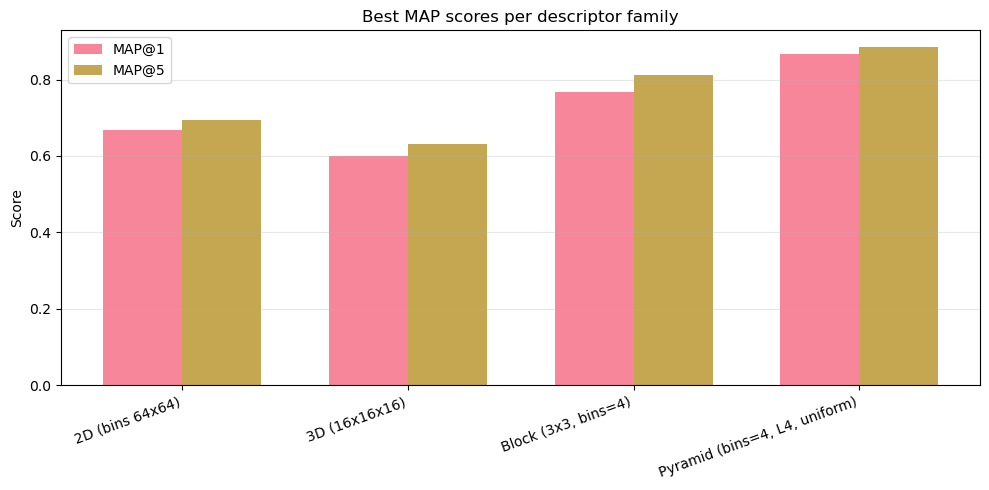


Weights used by the best pair in each family:
- 2D (bins 64x64):
    Pair: 2D_HSV_(0, 1)_bins64x64 + 2D_LAB_(1, 2)_bins64x64
    W1: [1.  0.5 0. ] | W2: [0.  0.  0.5]
- 3D (16x16x16):
    Pair: 3D_RGB_bins16x16x16 + 3D_HSV_bins16x16x16
    W1: [0.  0.  0.5] | W2: [0.  0.5 0.5]
- Block (3x3, bins=4):
    Pair: BLOCK_HSV_bins4_grid3x3 + BLOCK_HLS_bins4_grid3x3
    W1: [0.  1.  0.5] | W2: [1. 0. 0.]
- Pyramid (bins=4, L4, uniform):
    Pair: PYR_HSV_bins4_L4_uniform + PYR_HLS_bins4_L4_uniform
    W1: [0.  1.  0.5] | W2: [0.5 0.5 0. ]


In [ ]:
def best_from_results(all_results, descriptor_names, family_name):
    """
    all_results: list of tuples (map1, map5, (d1,d2), w1, w2), already sorted by MAP@1 then MAP@5
    Returns a dict row for the summary table.
    """
    if not all_results:
        return {
            "Method": family_name, "Best_Config": "—", "MAP@1": np.nan, "MAP@5": np.nan,
            "Pair": "—", "W1": "—", "W2": "—"
        }
    map1, map5, (d1, d2), w1, w2 = all_results[0]
    pair_name = f"{descriptor_names[d1]} + {descriptor_names[d2]}"
    return {
        "Method": family_name,
        "Best_Config": pair_name,
        "MAP@1": map1,
        "MAP@5": map5,
        "Pair": (d1, d2),
        "W1": np.round(w1, 2),
        "W2": np.round(w2, 2)
    }

# Build summary rows
summary_rows = []
summary_rows.append(best_from_results(results_2d,   descriptor_names_2d,   "2D (bins 64x64)"))
summary_rows.append(best_from_results(results_3d,   descriptor_names_3d,   "3D (16x16x16)"))
summary_rows.append(best_from_results(results_block,descriptor_names_block, "Block (3x3, bins=4)"))
summary_rows.append(best_from_results(results_pyr,  descriptor_names_pyr,  "Pyramid (bins=4, L4, uniform)"))

df_best = pd.DataFrame(summary_rows)
print("\n=== Best result per descriptor family ===")
print(df_best[["Method", "Best_Config", "MAP@1", "MAP@5"]].to_string(index=False))

# ---- Plot: Best MAP@1 and MAP@5 by family ----
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(df_best))
width = 0.35

ax.bar(x - width/2, df_best["MAP@1"], width, label="MAP@1", alpha=0.85)
ax.bar(x + width/2, df_best["MAP@5"], width, label="MAP@5", alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(df_best["Method"], rotation=20, ha="right")
ax.set_ylabel("Score")
ax.set_title("Best MAP scores per descriptor family")
ax.grid(True, axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) Pretty-print weights for the winner of each family
print("\nWeights used by the best pair in each family:")
for _, row in df_best.iterrows():
    print(f"- {row['Method']}:")
    print(f"    Pair: {row['Best_Config']}")
    print(f"    W1: {row['W1']} | W2: {row['W2']}")


## Test & Submission

In [ ]:
# --- CONFIG ---
TEST_DIR = "../Data/Week2/qst_w2/qst1_w2/"
K = 10
SUBMISSION_DIR = "submission_w2"
os.makedirs(SUBMISSION_DIR, exist_ok=True)

# Similarity names that are "similarity" (higher=better); we flip sign to treat all as distances
SIMILARITY_LIKES = {'histogram_intersection_matrix', 'hellinger_kernel_matrix',
                    'cosine_similarity_matrix', 'correlation_matrix'}

# -----------------------
# 1) Choose the best method
# -----------------------
# Expect: results_* = run_descriptor_pair_experiments(...), descriptor_names_* lists exist
def _pick_best_global(results_dict):
    """
    results_dict: {family_name: (results_list, descriptor_names, config_list)}
      - results_list: [(map1, map5, (d1,d2), w1, w2), ...], already sorted by MAP@1, then MAP@5
      - descriptor_names: names aligned with indices d1/d2
      - config_list: list of (name, fn) aligned with descriptor_names
    returns: dict with the winning family, pair, weights, and the two functions
    """
    best_items = []
    for fam, (res_list, names, cfgs) in results_dict.items():
        if not res_list: 
            continue
        map1, map5, (d1, d2), w1, w2 = res_list[0]
        best_items.append((map1, map5, fam, d1, d2, w1, w2, names, cfgs))
    if not best_items:
        raise RuntimeError("No results available to select best method.")
    # sort by MAP@1 then MAP@5
    best_items.sort(key=lambda x: (x[0], x[1]), reverse=True)
    map1, map5, fam, d1, d2, w1, w2, names, cfgs = best_items[0]

    # map name -> function
    name2fn = {n: fn for (n, fn) in cfgs}
    n1, n2 = names[d1], names[d2]
    if n1 not in name2fn or n2 not in name2fn:
        raise KeyError(f"Descriptor function not found for: {n1} or {n2}")
    return {
        "family": fam,
        "map1": float(map1),
        "map5": float(map5),
        "name1": n1, "name2": n2,
        "w1": np.array(w1, dtype=float),
        "w2": np.array(w2, dtype=float),
        "fn1": name2fn[n1], "fn2": name2fn[n2],
    }

# Build the inputs for the selector from what you already computed
# (Provide only the families you want to consider)
results_pool = {}
if 'results_2d' in globals():
    results_pool["2D (64x64)"] = (results_2d, descriptor_names_2d, configs_2d_64)
if 'results_3d' in globals():
    results_pool["3D (16x16x16)"] = (results_3d, descriptor_names_3d, configs_3d_16)
if 'results_block' in globals():
    results_pool["Block (3x3, bins=4)"] = (results_block, descriptor_names_block, configs_block_sel)
if 'results_pyr' in globals():
    results_pool["Pyramid (bins=4, L4, uniform)"] = (results_pyr, descriptor_names_pyr, configs_pyr_sel)

best = _pick_best_global(results_pool)
print("\n=== Best Week2 Method Selected ===")
print(f"Family     : {best['family']}")
print(f"Pair       : {best['name1']}  +  {best['name2']}")
print(f"MAP@1/5    : {best['map1']:.3f} / {best['map5']:.3f}")
print(f"W1 / W2    : {np.round(best['w1'],2)}  /  {np.round(best['w2'],2)}")

# ------------------------
# 2) Load test image list
# ------------------------
test_images = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith('.jpg')])
print(f"\nFound {len(test_images)} test queries in {TEST_DIR}")

# -------------------------------
# 3) Build descriptors (cached)
#    Only for the *two* best fns
# -------------------------------
def _wrap_cfg_from_best(best_obj):
    # Re-wrap as config lists for the cached builder API: [(name, fn)]
    return [(best_obj['name1'], best_obj['fn1']), (best_obj['name2'], best_obj['fn2'])]

best_cfgs = _wrap_cfg_from_best(best)

# DB descriptors (reuse your training DB set)
db_descs = build_descriptor_matrix_cached(
    best_cfgs, db_images, DEFAULT_DB_PATH, cache_dir="hp_cache", cache_prefix="W2BEST_db"
)
# Test descriptors (Week2 qst set)
qry_descs = build_descriptor_matrix_cached(
    best_cfgs, test_images, TEST_DIR, cache_dir="hp_cache", cache_prefix="W2BEST_q"
)

# -----------------------------------
# 4) Compute similarities for the two
# -----------------------------------
def _stack_for_two(qry_descs, db_descs, sim_funcs):
    stacks = []
    for i in range(2):
        stacks.append(np.stack([f(qry_descs[i], db_descs[i]) for f in sim_funcs], axis=-1))  # [Nq,Ndb,M]
    return stacks  # [desc_idx][Nq,Ndb,M]

sim_stacks = _stack_for_two(qry_descs, db_descs, similarity_matrix_funcs)  # list of two [Nq,Ndb,M]

# Convert any similarity-like matrices to distances (flip sign), so "smaller is better"
sim_names = [f.__name__ for f in similarity_matrix_funcs]
flip_mask = np.array([name in SIMILARITY_LIKES for name in sim_names], dtype=bool)

for i in range(2):
    sim_stacks[i][..., flip_mask] *= -1.0

# ------------------------------------
# 5) Fuse measures with best weights
# ------------------------------------
w1 = best['w1']
w2 = best['w2']
if w1.shape[0] != sim_stacks[0].shape[-1] or w2.shape[0] != sim_stacks[1].shape[-1]:
    raise ValueError("Weight length does not match number of similarity measures.")

weighted1 = np.tensordot(sim_stacks[0], w1, axes=([2], [0]))  # [Nq x Ndb]
weighted2 = np.tensordot(sim_stacks[1], w2, axes=([2], [0]))  # [Nq x Ndb]
combined = 0.5 * (weighted1 + weighted2)                       # [Nq x Ndb] distances

# ---------------------------------------------------
# 6) Rank & build submission list-of-lists of image IDs
# ---------------------------------------------------
submission = []
for qi in range(combined.shape[0]):
    # smaller distance is better
    topk = np.argsort(combined[qi])[:K]
    # convert db indices -> db image IDs (as in your Week1 format)
    topk_ids = [filename_to_id(db_images[idx]) for idx in topk]
    submission.append(topk_ids)

# --------------------------------
# 7) Save result.pkl and summary
# --------------------------------
method_dir = os.path.join(SUBMISSION_DIR, "method1")
os.makedirs(method_dir, exist_ok=True)

# result.pkl
with open(os.path.join(method_dir, "result.pkl"), "wb") as f:
    pickle.dump(submission, f)

# summary JSON
summary = {
    "team": "Team2",
    "week": 2,
    "dataset": "QST1_W2",
    "method": {
        "family": best["family"],
        "descriptor_pair": [best["name1"], best["name2"]],
        "weights1": best["w1"].tolist(),
        "weights2": best["w2"].tolist(),
        "similarity_measures": sim_names,
    },
    "k_results": K,
    "num_queries": len(submission),
    "format": "List of lists of DB image IDs (length K per query)"
}
with open(os.path.join(SUBMISSION_DIR, "methods_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n✅ Week2 submission files written:")
print(" -", os.path.join(method_dir, "result.pkl"))
print(" -", os.path.join(SUBMISSION_DIR, "methods_summary.json"))

# (Optional) quick sanity: preview first 2 queries
for i in range(min(2, len(submission))):
    print(f"Q{i}: {submission[i]}")



=== Best Week2 Method Selected ===
Family     : Pyramid (bins=4, L4, uniform)
Pair       : PYR_HSV_bins4_L4_uniform  +  PYR_HLS_bins4_L4_uniform
MAP@1/5    : 0.867 / 0.884
W1 / W2    : [0.  1.  0.5]  /  [0.5 0.5 0. ]

Found 30 test queries in ../Data/Week2/qst_w2/qst1_w2/


Building descriptors (W2BEST_q): 100%|██████████| 2/2 [00:01<00:00,  1.40desc/s]



✅ Week2 submission files written:
 - submission_w2\method1\result.pkl
 - submission_w2\methods_summary.json
Q0: [194, 97, 42, 205, 40, 16, 93, 236, 90, 35]
Q1: [131, 142, 139, 37, 180, 230, 110, 57, 240, 259]


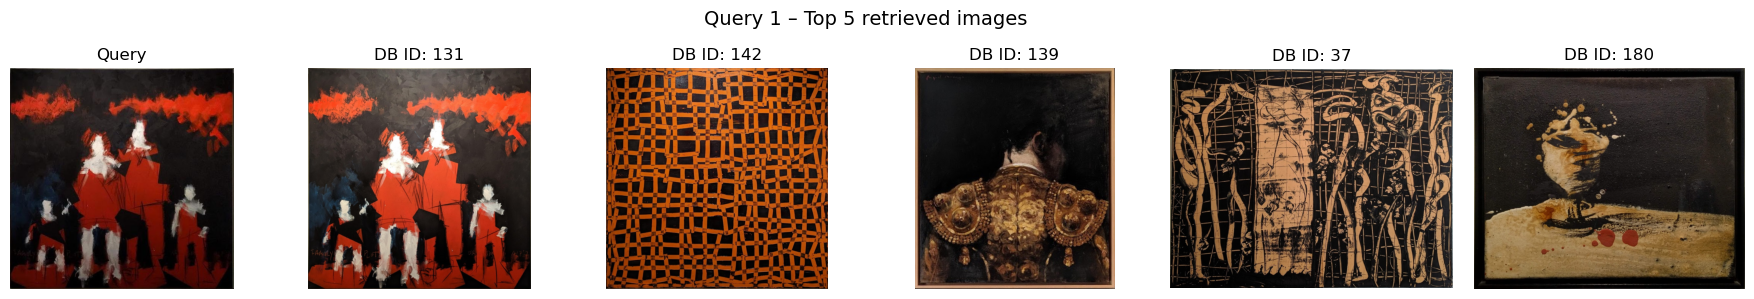

In [ ]:
def show_query_results(query_idx, submission, test_images, test_dir, db_images, db_dir, K=5):
    """
    Show the query image and its top-K retrieved DB images.
    """
    query_path = os.path.join(test_dir, test_images[query_idx])
    query_img = cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB)
    
    # Get top-K retrieved IDs for this query
    top_ids = submission[query_idx][:K]
    
    # Find their filenames in db_images (matching the numeric ID in filename)
    retrieved_paths = []
    for img_id in top_ids:
        for fname in db_images:
            if str(img_id) in fname:
                retrieved_paths.append(os.path.join(db_dir, fname))
                break

    # --- Plot ---
    fig, axes = plt.subplots(1, K + 1, figsize=(3*(K+1), 3))
    fig.suptitle(f"Query {query_idx} – Top {K} retrieved images", fontsize=14)
    
    # Query image
    axes[0].imshow(query_img)
    axes[0].set_title("Query")
    axes[0].axis('off')
    
    # Retrieved images
    for i, path in enumerate(retrieved_paths):
        if i >= K: break
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"DB ID: {top_ids[i]}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_query_results(
    query_idx=1,                       # change to any query number
    submission=submission,             # the result list of lists
    test_images=test_images,           # filenames in your Week2 test folder
    test_dir=TEST_DIR,                 # "../Data/Week2/qst_w2/qst1_w2/"
    db_images=db_images,               # filenames in your DB folder
    db_dir=DEFAULT_DB_PATH,            # "../Data/BBDD/"
    K=5                                # how many retrieved images to show
)
